<font size='8'>Salary Prediction</font>

<font size='6'>Data Cleaning</font>

In [171]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import set_config
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    PolynomialFeatures,
    StandardScaler,
)
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso, 
    ElasticNet,
    SGDRegressor,
)
from sklearn.metrics import mean_squared_error, mean_absolute_error

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import mse, mae
from keras.saving import load_model

import keras_tuner as kt

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

<font size='4'>Read data</font>

In [172]:
FILE_NAME = "Salary_Data.csv"
df = pd.read_csv(FILE_NAME, delimiter=',')
df

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0
...,...,...,...,...,...,...
6699,49.0,Female,PhD,Director of Marketing,20.0,200000.0
6700,32.0,Male,High School,Sales Associate,3.0,50000.0
6701,30.0,Female,Bachelor's Degree,Financial Manager,4.0,55000.0
6702,46.0,Male,Master's Degree,Marketing Manager,14.0,140000.0


<font size='4'>Save a copy data</font>

In [173]:
df_raw = df[df['Age'] > 30]
print(df_raw._is_view)

False


<font size='6'>Data Cleaning</font>

<font size='4'>Rename columns</font>

In [174]:
print(df.columns)
def cleaning_rename_cols(df):
    df.columns = [col.replace(' ', '_').lower() for col in df.columns]
    print('rename column - Successful ...')

cleaning_rename_cols(df)
print(df.columns)

Index(['Age', 'Gender', 'Education Level', 'Job Title', 'Years of Experience',
       'Salary'],
      dtype='object')
rename column - Successful ...
Index(['age', 'gender', 'education_level', 'job_title', 'years_of_experience',
       'salary'],
      dtype='object')


<font size='4'>Check columns values</font>

In [175]:
for col in df.columns:
    # print(f"{col}:\n{df[col].info()}", end='\n\n')
    print(f"{col}:\n"
          f"null: {df[col].isnull().any()}\n"
          f"NaN:  {df[col].isna().any()}", end='\n\n')

age:
null: True
NaN:  True

gender:
null: True
NaN:  True

education_level:
null: True
NaN:  True

job_title:
null: True
NaN:  True

years_of_experience:
null: True
NaN:  True

salary:
null: True
NaN:  True



<font size='3'>remove Target column missing value rows</font>

In [176]:
# df = df.dropna(subset=['salary']).reset_index()          # create index column, keep all index
def cleaning_nan_salary(df) -> pd.DataFrame:
    return df.dropna(subset=['salary']).reset_index(drop=True)

df = cleaning_nan_salary(df)
# cleaning_nan_salary(df)
print(df['salary'].isna().any())
print(df['salary'].isnull().any())


False
False


<font size='3'>check Target column outliner, and address it</font>

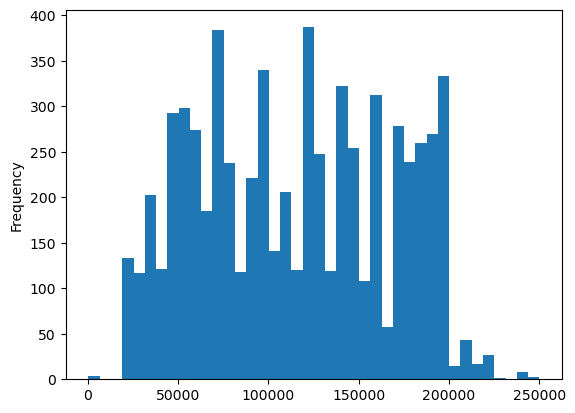

In [177]:
# plt.hist(df['salary'], bins=32)
# sns.violinplot(x=df['salary'])
df['salary'].plot(kind='hist', bins=40)
plt.show()

<font size='3'>check minimum, remove unreasonable data</font>

In [178]:
print(df.sort_values(by=['salary']).head(10), end='\n\n')

def cleaning_remove_salary_outlier(df, lower_bound=10000) -> pd.DataFrame:
    df['salary'] = df['salary'].astype('int32')
    df = df[df['salary'] > lower_bound]
    return df

df = cleaning_remove_salary_outlier(df)
print(df.sort_values(by=['salary']).head(10))

       age  gender    education_level                           job_title  years_of_experience   salary
258   29.0    Male         Bachelor's  Junior Business Operations Analyst                  1.5    350.0
4630  31.0  Female  Bachelor's Degree               Junior HR Coordinator                  4.0    500.0
1888  25.0  Female  Bachelor's Degree                 Front end Developer                  1.0    550.0
2652  23.0    Male                PhD           Software Engineer Manager                  1.0    579.0
4920  21.0  Female        High School         Junior Sales Representative                  0.0  25000.0
4933  21.0  Female        High School         Junior Sales Representative                  0.0  25000.0
4946  21.0  Female        High School         Junior Sales Representative                  0.0  25000.0
4959  21.0  Female        High School         Junior Sales Representative                  0.0  25000.0
4972  21.0  Female        High School         Junior Sales Repre

<font size='3'>check maximum, remove unreasonable data</font>

In [179]:
print(df.sort_values(by=['salary']).tail(10), end='\n\n')

# def remove_outlier_upper(df, col, upper_bound=10000):
#     return df[df[col] < upper_bound]


# df = remove_outlier_lower(df, 'salary')
# print(df.sort_values(by=['salary']).tail(10))

       age gender    education_level                 job_title  years_of_experience  salary
4288  51.0   Male                PhD            Data Scientist                 24.0  240000
4378  51.0   Male                PhD            Data Scientist                 24.0  240000
4348  51.0   Male                PhD            Data Scientist                 24.0  240000
4303  51.0   Male                PhD            Data Scientist                 24.0  240000
4363  51.0   Male                PhD            Data Scientist                 24.0  240000
4333  51.0   Male                PhD            Data Scientist                 24.0  240000
4273  51.0   Male                PhD            Data Scientist                 24.0  240000
4998  45.0   Male  Bachelor's Degree         Financial Manager                 21.0  250000
30    50.0   Male         Bachelor's                       CEO                 25.0  250000
83    52.0   Male                PhD  Chief Technology Officer                 2

In [180]:
def cleaning_salary(df):
    df = cleaning_nan_salary(df)
    print("cleaning nan salary - Successful ...")
    df = cleaning_remove_salary_outlier(df)
    print("cleaning salary outlier - Successful ...")
    return df

df = cleaning_salary(df)
df

cleaning nan salary - Successful ...
cleaning salary outlier - Successful ...


,age,gender,education_level,job_title,years_of_experience,salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000
1,28.0,Female,Master's,Data Analyst,3.0,65000
2,45.0,Male,PhD,Senior Manager,15.0,150000
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000
4,52.0,Male,Master's,Director,20.0,200000
...,...,...,...,...,...,...
6690,49.0,Female,PhD,Director of Marketing,20.0,200000
6691,32.0,Male,High School,Sales Associate,3.0,50000
6692,30.0,Female,Bachelor's Degree,Financial Manager,4.0,55000
6693,46.0,Male,Master's Degree,Marketing Manager,14.0,140000


In [181]:
# def remove_outlier(df, col, t_fac=2.5):
#     ## version 1
#     # mean_ = df[col].mean()
#     # std_ = df[col].std()
#     # upper_bound = mean_ + t_fac * std_
#     # lower_bound = mean_ - t_fac * std_


#     ## version 2
#     q1 = df[col].quantile(0.25)
#     q3 = df[col].quantile(0.75)
#     IQR = t_fac * (q3 - q1)
#     upper_bound, lower_bound = q3 + IQR, q1 - IQR

#     return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# df = remove_outlier(df, 'salary', t_fac=0.7)

# df['salary'].plot(kind='hist', bins=40)
# plt.show()

<font size='4'>Check again columns values</font>

In [182]:
for col in df.columns:
    print(f"{col}:\n"
          f"null: {df[col].isnull().any()}\n"
          f"NaN: {df[col].isna().any()}", end='\n\n')

age:
null: False
NaN: False

gender:
null: False
NaN: False

education_level:
null: True
NaN: True

job_title:
null: False
NaN: False

years_of_experience:
null: False
NaN: False

salary:
null: False
NaN: False



<font size='4'>Check each feature(column)</font>

<font size='3'>feature: age</font>

In [183]:
df['age'].unique() # no NaN

def cleaning_age(df):
    # df.loc[:, 'age'] = df['age'].astype('int32')
    df['age'] = df['age'].astype('int32')
    print('cleaning age - Successful ...')

cleaning_age(df)
df['age'].unique()

cleaning age - Successful ...


array([32, 28, 45, 36, 52, 29, 42, 31, 26, 38, 48, 35, 40, 27, 44, 33, 39,
       25, 51, 34, 47, 30, 41, 37, 24, 43, 50, 46, 49, 23, 53, 61, 57, 62,
       55, 56, 54, 60, 58, 22, 21], dtype=int32)

<font size='3'>feature: gender</font>

In [184]:
df['gender'].unique() # no NaN


def cleaning_gender(df):
    mapping = {'Male': 'male', 'Female': 'female', 'Other': 'other'}
    # df.loc[:, 'gender'] = df['gender'].map(mapping).fillna(df['gender'])
    df['gender'] = df['gender'].map(mapping).fillna(df['gender'])
    print('cleaning gender - Successful ...')

cleaning_gender(df)
df['gender'].unique()

cleaning gender - Successful ...


array(['male', 'female', 'other'], dtype=object)

<font size='3'>feature: education_level</font>

In [185]:
df['education_level'].unique()

def cleaning_edu(df):
    el_str = df['education_level'].str.lower()
    # df.loc[:, 'education_level'] = np.select(
    df['education_level'] = np.select(
        condlist=[
            el_str.str.contains('bachelor', na=False),
            el_str.str.contains('master', na=False),
            el_str.str.contains('phd', na=False),
            el_str.str.contains('high school', na=False),
        ],
        choicelist=[
            'Bachelor',
            'Master',
            'PhD',
            'High School'
        ],
        default='No Specified',
    ).astype('str')
    print('cleaning education level - Successful ...')


cleaning_edu(df)
df['education_level'].unique()

cleaning education level - Successful ...


array(['Bachelor', 'Master', 'PhD', 'No Specified', 'High School'],
      dtype=object)

<font size='3'>feature: job_title</font>

In [186]:
df['job_title'].unique()

def cleaning_job(df):
    df.loc[:, 'job_title'] = (
        df['job_title']
        # .str
        # .replace(r'\b(Junior|Juniour|Senior)\b\s+', '', regex=True)
        .str.strip()
        .astype('str')
    )
    print('cleaning job title - Successful ...')

cleaning_job(df)
df['job_title'].unique()

cleaning job title - Successful ...


array(['Software Engineer', 'Data Analyst', 'Senior Manager',
       'Sales Associate', 'Director', 'Marketing Analyst',
       'Product Manager', 'Sales Manager', 'Marketing Coordinator',
       'Senior Scientist', 'Software Developer', 'HR Manager',
       'Financial Analyst', 'Project Manager', 'Customer Service Rep',
       'Operations Manager', 'Marketing Manager', 'Senior Engineer',
       'Data Entry Clerk', 'Sales Director', 'Business Analyst',
       'VP of Operations', 'IT Support', 'Recruiter', 'Financial Manager',
       'Social Media Specialist', 'Software Manager', 'Junior Developer',
       'Senior Consultant', 'Product Designer', 'CEO', 'Accountant',
       'Data Scientist', 'Marketing Specialist', 'Technical Writer',
       'HR Generalist', 'Project Engineer', 'Customer Success Rep',
       'Sales Executive', 'UX Designer', 'Operations Director',
       'Network Engineer', 'Administrative Assistant',
       'Strategy Consultant', 'Copywriter', 'Account Manager',
      

<font size='3'>feature: years_of_experience</font>

In [187]:
df['years_of_experience'].unique()

def cleaning_exp(df):
    # df.loc[:, 'years_of_experience'] = df['years_of_experience'].astype('float32')
    df['years_of_experience'] = df['years_of_experience'].astype('float32')
    print('cleaning years of experience - Successful ...')

cleaning_exp(df)
df['years_of_experience'].unique()

cleaning years of experience - Successful ...


array([ 5. ,  3. , 15. ,  7. , 20. ,  2. , 12. ,  4. ,  1. , 10. , 18. ,
        6. , 14. , 16. ,  0. , 22. , 19. ,  9. , 13. , 11. , 25. , 21. ,
        8. , 17. , 23. , 24. ,  0.5,  1.5, 31. , 30. , 28. , 33. , 27. ,
       34. , 29. , 26. , 32. ], dtype=float32)

In [188]:
def data_cleaning(df, has_target=False):
    cleaning_rename_cols(df)
    if has_target:
        df = cleaning_salary(df)
    cleaning_age(df)
    cleaning_gender(df)
    cleaning_edu(df)
    cleaning_job(df)
    cleaning_exp(df)

    print("... Finishing Cleaning Process ...")

data_cleaning(df, has_target=True)

rename column - Successful ...
cleaning nan salary - Successful ...
cleaning salary outlier - Successful ...
cleaning age - Successful ...
cleaning gender - Successful ...
cleaning education level - Successful ...
cleaning job title - Successful ...
cleaning years of experience - Successful ...
... Finishing Cleaning Process ...


<font size='6'>Data Visualization</font>

In [189]:
df

,age,gender,education_level,job_title,years_of_experience,salary
0,32,male,Bachelor,Software Engineer,5.0,90000
1,28,female,Master,Data Analyst,3.0,65000
2,45,male,PhD,Senior Manager,15.0,150000
3,36,female,Bachelor,Sales Associate,7.0,60000
4,52,male,Master,Director,20.0,200000
...,...,...,...,...,...,...
6690,49,female,PhD,Director of Marketing,20.0,200000
6691,32,male,High School,Sales Associate,3.0,50000
6692,30,female,Bachelor,Financial Manager,4.0,55000
6693,46,male,Master,Marketing Manager,14.0,140000


In [190]:
gen_ord = ['female', 'male', 'other']
df['gender'] = pd.Categorical(df['gender'], categories=gen_ord, ordered=True)

edu_ord = ['No Specified', 'High School', 'Bachelor', 'Master', 'PhD']
df['education_level'] = pd.Categorical(df['education_level'], categories=edu_ord, ordered=True)

## set save images file
images_dir = os.path.join(os.getcwd(), 'images')
os.makedirs(images_dir, exist_ok=True)

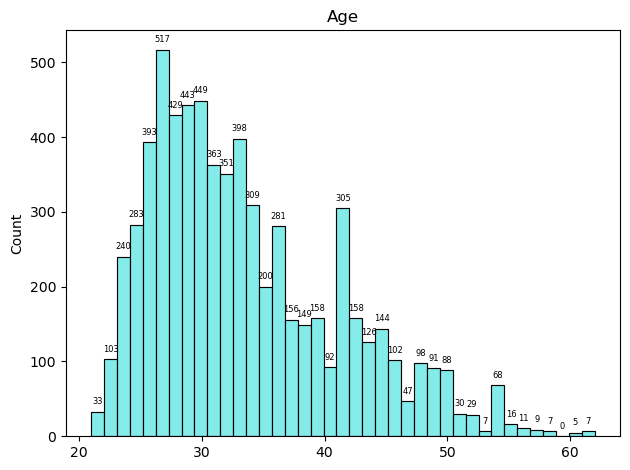

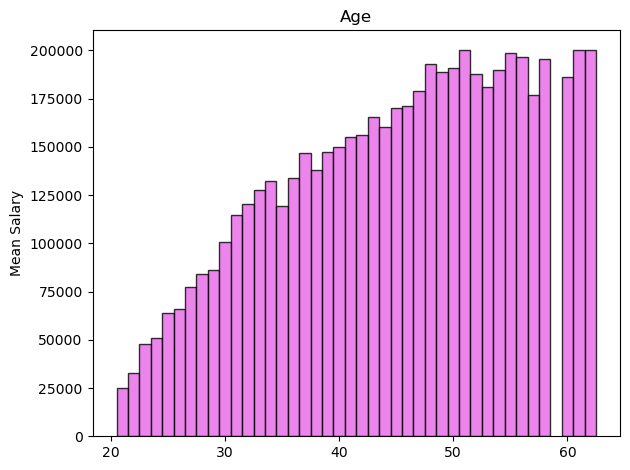

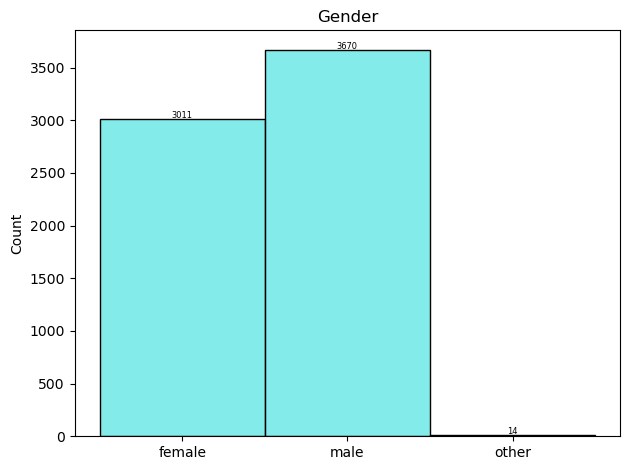

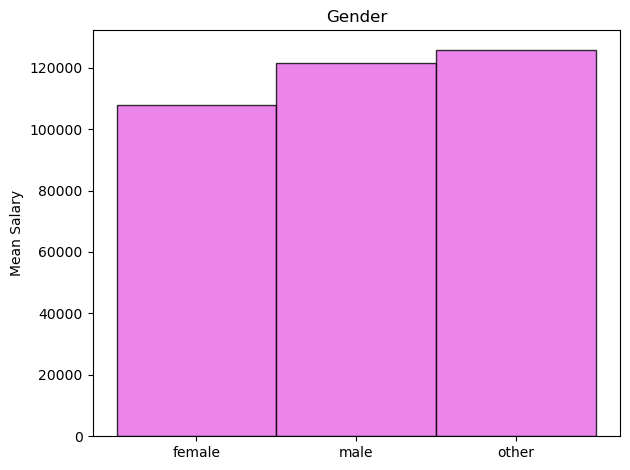

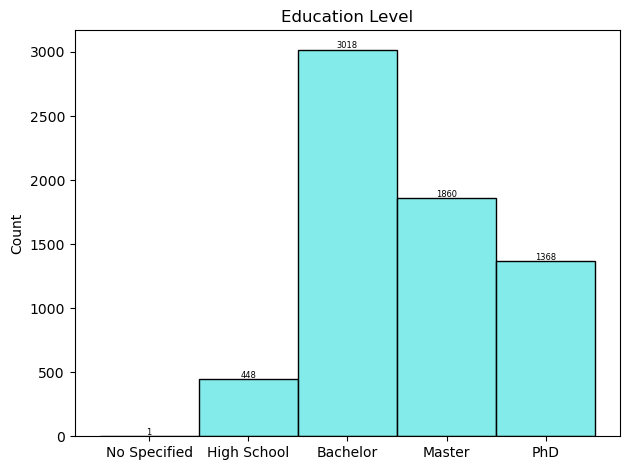

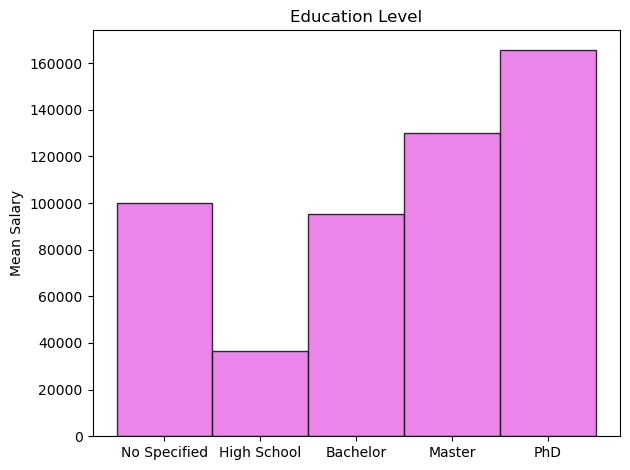

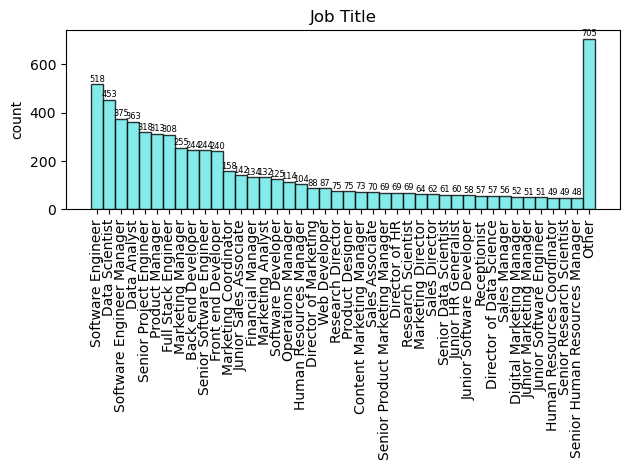

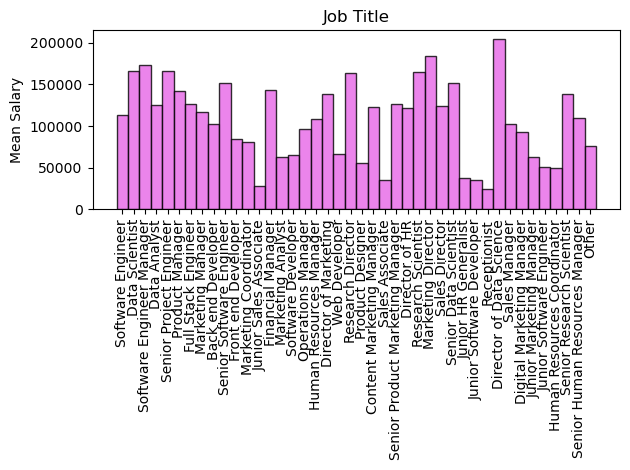

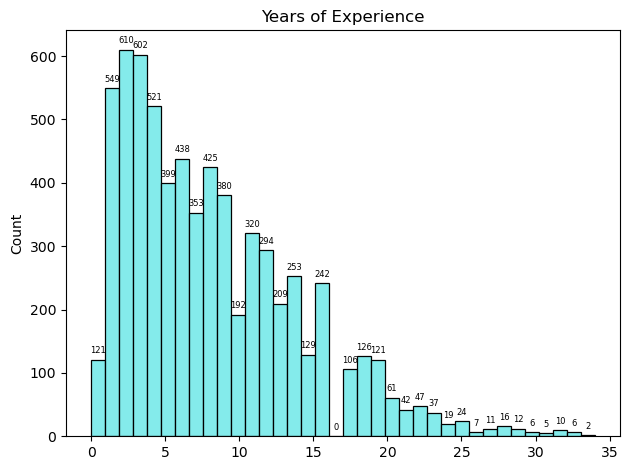

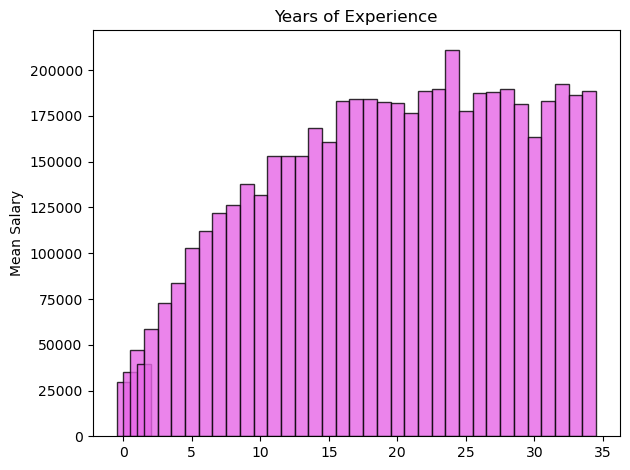

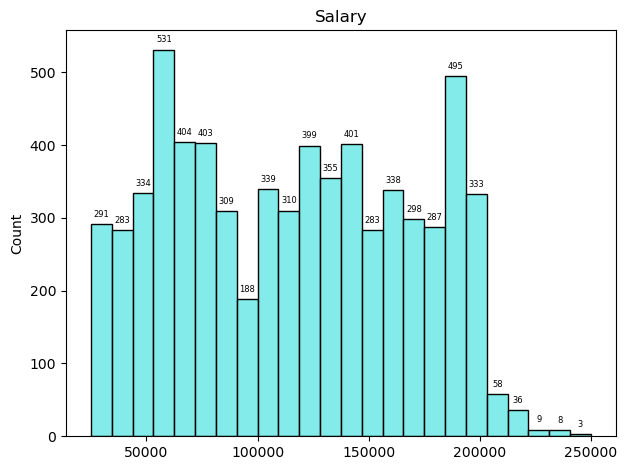

In [191]:
def show_plot(df, col):
    title_ = col

    ## show distribution
    if col == 'job_title':
        plt.xticks(rotation=90)

        threshold = 45
        agg_job = df[col].value_counts()
        valid_job = agg_job[agg_job > threshold]
        valid_job.loc['Other'] = agg_job[agg_job <= threshold].sum()

        bars = sns.barplot(data=valid_job,
                           color=(0.4, 0.9, 0.9),
                           edgecolor='black',
                           saturation=1,
                           alpha=0.8,
                           width=1)
        bars.margins(x=0.05)

    else :
        bars = sns.histplot(data=df,
                            x=col,
                            color=(0.4, 0.9, 0.9),
                            alpha=0.8)

    for bar in bars.patches:
        bbox = bar.get_bbox()
        x0 = bbox.x0
        width = bbox.width
        height = bbox.y1 - bbox.y0
        x_position = x0 + width / 2
        bars.text(x=x_position, y=height + 10,
                  s=f"{int(height)}",
                  ha='center',
                  fontsize=6)

    if '_' not in title_:
        title_ = title_[0].upper() + title_[1:]
    else :
        title_ = " ".join([n_split.capitalize()
                           if n_split != 'of'
                           else n_split
                           for n_split in title_.split('_')])

    plt.xlabel('')
    plt.title(title_)
    plt.tight_layout()

    ## save image
    fig_fname = f'{col}_distribution.png'
    plt.savefig(os.path.join(images_dir, fig_fname), bbox_inches='tight')

    ## plot image
    plt.show()

    if col == 'salary':
        return

    ## show relation with target feature
    d = df.groupby([col], observed=False)['salary'].mean()

    if col == 'job_title':
        plt.xticks(rotation=90)
        # threshold = 70
        agg_job = df[col].value_counts()
        valid_job_index = agg_job[agg_job > threshold].index

        temp_ = df[[col, 'salary']].copy()
        temp_[col] = temp_[col].where(temp_[col].isin(valid_job_index), other='Other')
        d = temp_.groupby([col])['salary'].mean()
        valid_job_index = list(valid_job_index) + ['Other']
        d = d.reindex(valid_job_index)

    plt.bar(d.index, d.values, width=1, color=(0.9, 0.4, 0.9),
            edgecolor='black', alpha=0.8)

    plt.xlabel('')
    plt.ylabel('Mean Salary')
    plt.title(title_)
    plt.tight_layout()

    ## save image
    fig_fname = f'{col}_salary_relation.png'
    plt.savefig(os.path.join(images_dir, fig_fname), bbox_inches='tight')

    ## plot image
    plt.show()




for col in df.columns:
    show_plot(df, col)

In [192]:
df_cleaned = df.copy()
df_cleaned

,age,gender,education_level,job_title,years_of_experience,salary
0,32,male,Bachelor,Software Engineer,5.0,90000
1,28,female,Master,Data Analyst,3.0,65000
2,45,male,PhD,Senior Manager,15.0,150000
3,36,female,Bachelor,Sales Associate,7.0,60000
4,52,male,Master,Director,20.0,200000
...,...,...,...,...,...,...
6690,49,female,PhD,Director of Marketing,20.0,200000
6691,32,male,High School,Sales Associate,3.0,50000
6692,30,female,Bachelor,Financial Manager,4.0,55000
6693,46,male,Master,Marketing Manager,14.0,140000


<font size='6'>Data Spliting</font>

In [193]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]


In [194]:
# train set size = 0.8
# test set size  = 0.2

X_train, X_test, y_train, y_test \
    = train_test_split(X, y, test_size=0.2, random_state=1234)

X_train
# y_train
X_test
# y_test

,age,gender,education_level,job_title,years_of_experience
6565,36,male,Bachelor,Sales Director,6.0
1514,54,male,PhD,Software Engineer Manager,17.0
6237,29,male,Bachelor,Marketing Analyst,4.0
5460,26,female,Bachelor,Social Media Manager,3.0
5314,28,male,Bachelor,Product Designer,3.0
...,...,...,...,...,...
4473,41,male,PhD,Data Scientist,15.0
6617,28,male,PhD,Marketing Manager,4.0
1036,25,female,Bachelor,Data Analyst,2.0
2008,31,female,Bachelor,Front end Developer,6.0


<font size='6'>Data Preprocessing</font>

<font size='4' color='lightblue'>Linear Regression</font>

<font size='4' color='lightblue'>Polynomial Regression</font>

In [195]:
is_poly = True

# ordinal_ord = ['No Specified', 'High School', 'Bachelor', 'Master', 'PhD']
if is_poly: 
    poly_feature_col = ['age', 'years_of_experience']
    # poly_feature_col = ['age', 'years_of_experience',
    #                     'education_level', 'job_title']
    scaler_col = ['age', 'job_title',
                  'years_of_experience', 'education_level',
                  'age^2', 'years_of_experience^2',
                  'age years_of_experience']
else :
    scaler_col = ['age', 'job_title',
                  'years_of_experience', 'education_level']


In [196]:
set_config(transform_output='pandas')

preprocessor = ColumnTransformer(
    transformers=[
        ('gen_encoder',
         OneHotEncoder(sparse_output=False),
         ['gender']),
        # ('edu_encoder',
        #  OrdinalEncoder(categories=[ordinal_ord]),
        # ['education_level']),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False,
)

poly_step = ColumnTransformer(
    transformers=[
        ('poly',
         PolynomialFeatures(include_bias=False),
         poly_feature_col),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False,
)

scaler_step = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), scaler_col)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False,
)

if is_poly: 
    features_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('job_encode', TargetEncoder(cols=['job_title', 'education_level'])),
        ('poly', poly_step),
        ('scaler', scaler_step),
    ])
else :
    features_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('job_encode', TargetEncoder(cols=['job_title'])),
        ('scaler', scaler_step),
    ])

# model_pipeline = Pipeline([
#     ('feature', features_pipeline),
#     ('model', LinearRegression()),
# ])

X_train_ = features_pipeline.fit_transform(X_train, y_train)
X_train_
X_test_ = features_pipeline.transform(X_test)
X_test_

,age,job_title,years_of_experience,education_level,age^2,years_of_experience^2,age years_of_experience,gender_female,gender_male,gender_other
6565,0.303821,0.083906,-0.346411,-0.592110,0.180713,-0.464407,-0.327993,0.0,1.0,0.0
1514,2.651778,1.393586,1.451595,1.464689,3.009164,1.280092,1.943495,0.0,1.0,0.0
6237,-0.609273,-1.357287,-0.673322,-0.592110,-0.613698,-0.602312,-0.651567,0.0,1.0,0.0
5460,-1.000600,-0.488397,-0.836777,-0.592110,-0.901781,-0.650578,-0.774525,1.0,0.0,0.0
5314,-0.739716,-1.508020,-0.836777,-0.592110,-0.713218,-0.650578,-0.755111,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
4473,0.956031,1.224235,1.124685,1.464689,0.852907,0.838796,0.963066,0.0,1.0,0.0
6617,-0.739716,0.087862,-0.673322,1.464689,-0.713218,-0.602312,-0.664510,0.0,1.0,0.0
1036,-1.131042,0.146082,-1.000232,-0.592110,-0.990825,-0.685055,-0.865126,1.0,0.0,0.0
2008,-0.348389,-0.804410,-0.346411,-0.592110,-0.404183,-0.464407,-0.425065,1.0,0.0,0.0


<font size='4'>Show heatmap in all features</font>

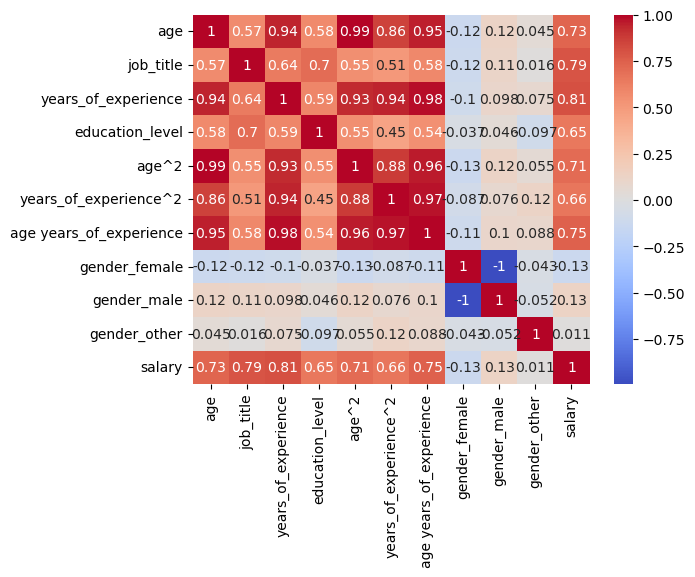

In [197]:
heatmap_df = X_train_.copy()
heatmap_df['salary'] = y_train
sns.heatmap(heatmap_df.corr(), annot=True, cmap='coolwarm')

## save fig
plt.savefig(os.path.join(images_dir, 'features_heatmap.png'),
            bbox_inches='tight')
## show fig
plt.show()

<font size='6'>Training</font>

In [198]:
X_train
X_train_
# y_train

,age,job_title,years_of_experience,education_level,age^2,years_of_experience^2,age years_of_experience,gender_female,gender_male,gender_other
3858,-0.870158,-2.238004,-1.000232,-2.262515,-0.809245,-0.685055,-0.852183,0.0,1.0,0.0
4786,-0.478831,-1.220604,-0.673322,-0.592110,-0.510686,-0.602312,-0.638624,1.0,0.0,0.0
2739,1.869126,2.078278,1.615050,1.464689,1.940638,1.521426,1.768765,0.0,1.0,0.0
191,-0.478831,-0.280851,-0.836777,-0.592110,-0.510686,-0.650578,-0.735696,1.0,0.0,0.0
2294,-0.478831,-0.127323,-0.509866,-0.592110,-0.510686,-0.540254,-0.541552,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
664,-0.478831,1.224235,-0.182956,1.464689,-0.510686,-0.374768,-0.347408,1.0,0.0,0.0
3276,0.173379,0.146082,0.143954,0.435507,0.056750,-0.154120,-0.007655,1.0,0.0,0.0
1318,-0.870158,-0.804410,-0.836777,-0.592110,-0.809245,-0.650578,-0.764818,0.0,1.0,0.0
723,-0.870158,-0.127323,-0.673322,-0.592110,-0.809245,-0.602312,-0.677453,0.0,1.0,0.0


<font size='4'>fit</font>

In [199]:
parm_space = [
    {
        'penalty': Categorical(['elasticnet']),
        'alpha': Real(1e-5, 1e+1, prior='log-uniform'),
        'max_iter': Integer(1000, 5000, prior='uniform'),
        'tol': Real(1e-5, 1e-3, prior='log-uniform'),
        'l1_ratio': Real(0.1, 0.9, prior='uniform'),
        'learning_rate': Categorical(['adaptive', 'constant']),
        'eta0': Real(1e-3, 1, prior='log-uniform'),
    },
    {
        'penalty': Categorical(['l1']),
        'alpha': Real(1e-5, 1e+1, prior='log-uniform'),
        'max_iter': Integer(1000, 5000, prior='uniform'),
        'tol': Real(1e-5, 1e-3, prior='log-uniform'),
        'learning_rate': Categorical(['adaptive', 'constant']),
        'eta0': Real(1e-3, 1, prior='log-uniform'),
    },
    {
        'penalty': Categorical(['l2']),
        'alpha': Real(1e-5, 1e+1, prior='log-uniform'),
        'max_iter': Integer(1000, 5000, prior='uniform'),
        'tol': Real(1e-5, 1e-3, prior='log-uniform'),
        'learning_rate': Categorical(['adaptive', 'constant']),
        'eta0': Real(1e-3, 1, prior='log-uniform'),
    },
]

common_paras = {
    'n_iter': 30,
    'cv': 5,
    'n_jobs': -1,
    # 'random_state': 34,
    'scoring': 'neg_mean_squared_error',
}

linear_model = BayesSearchCV(
    estimator=SGDRegressor(early_stopping=True),
    search_spaces=parm_space,
    **common_paras,
    # verbose=0,
)

linear_model.fit(X_train_, y_train)
y_pred_ln = linear_model.predict(X_test_)



/opt/anaconda3/envs/ML_env/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [200]:
ln_df = X_test.copy()
ln_df['true_salary'] = y_test

ln_df[f'predict'] = y_pred_ln
ln_df[f'difference'] = ln_df['true_salary'] - ln_df[f'predict']

ln_df

,age,gender,education_level,job_title,years_of_experience,true_salary,predict,difference
6565,36,male,Bachelor,Sales Director,6.0,75000,93237.551168,-18237.551168
1514,54,male,PhD,Software Engineer Manager,17.0,195000,188693.564284,6306.435716
6237,29,male,Bachelor,Marketing Analyst,4.0,75000,68558.595261,6441.404739
5460,26,female,Bachelor,Social Media Manager,3.0,55000,82243.890181,-27243.890181
5314,28,male,Bachelor,Product Designer,3.0,60000,56955.141968,3044.858032
...,...,...,...,...,...,...,...,...
4473,41,male,PhD,Data Scientist,15.0,157000,179929.609526,-22929.609526
6617,28,male,PhD,Marketing Manager,4.0,55000,97820.114016,-42820.114016
1036,25,female,Bachelor,Data Analyst,2.0,100000,84790.874995,15209.125005
2008,31,female,Bachelor,Front end Developer,6.0,110000,92322.059664,17677.940336


<font size='6'>Assess Model</font>

In [201]:
parm_dict = linear_model.best_params_
if parm_dict.get('penalty', '') != 'elasticnet':
    parm_dict.pop('l1_ratio', None)

print(f"Linear Model:")
for i, v in parm_dict.items():
    # print(type(i), type(v))
    if type(v) == float:
        print(f"    {i}: {v:.6f}")
    else :
        print(f"    {i}: {v}")

print(f"    mse: {mean_squared_error(y_test, y_pred_ln):.2f}")
print(f"    mae: {mean_absolute_error(y_test, y_pred_ln):.2f}")

Linear Model:
    alpha: 0.360525
    eta0: 0.014700
    learning_rate: adaptive
    max_iter: 1857
    penalty: l1
    tol: 0.000135
    mse: 481831664.35
    mae: 16589.71


<font size='6'>Predict</font>

Given an exmaple, we should predict it</br>
assume example has no NaN

In [202]:
df.columns.difference(['salary'], sort=False)

Index(['age', 'gender', 'education_level', 'job_title', 'years_of_experience'], dtype='object')

In [203]:
example_dataset = np.array([
    [26, 'Male', "Master", "Data Analyst", 0],
    [26, 'Female', "Master", "Data Analyst", 0],
    [27, 'Male', "Master", "Data Analyst", 0],
    [27, 'Female', "Master", "Data Analyst", 0],
    [27, 'Male', "Master", "Data Analyst", 1],
    [27, 'Female', "Master", "Data Analyst", 1],
])

example_df = pd.DataFrame(example_dataset,
                          columns=df \
                            .columns \
                            .difference(['salary'], sort=False))

data_cleaning(example_df)
# example_df.info()

example_df_ = features_pipeline.transform(example_df)
# example_df_

y_pred_ex = linear_model.predict(example_df_)
example_df['predict_linear'] = y_pred_ex

if is_poly:
    print("Using Polynomial_LinearModel")
else :
    print("Using LinearModel")

example_df

rename column - Successful ...
cleaning age - Successful ...
cleaning gender - Successful ...
cleaning education level - Successful ...
cleaning job title - Successful ...
cleaning years of experience - Successful ...
... Finishing Cleaning Process ...
Using Polynomial_LinearModel


,age,gender,education_level,job_title,years_of_experience,predict_linear
0,26,male,Master,Data Analyst,0.0,51264.842596
1,26,female,Master,Data Analyst,0.0,48685.736363
2,27,male,Master,Data Analyst,0.0,46044.421676
3,27,female,Master,Data Analyst,0.0,43465.315444
4,27,male,Master,Data Analyst,1.0,61799.247431
5,27,female,Master,Data Analyst,1.0,59220.141198


<font size='6' color='lightblue'>Neural Network</font>

In [204]:
X_train
X_train_
y_train
# X_test
# X_test_
# y_test


3858     35000
4786     57000
2739    210000
191      45000
2294     90000
         ...  
664     185000
3276    120000
1318     80000
723     140000
2863    180367
Name: salary, Length: 5356, dtype: int32

In [205]:
tuner_json_path = os.path.join(os.getcwd(), 'untitled_project/tuner0.json')
## remove tuner0.json 
if os.path.isfile(tuner_json_path):
    os.remove(tuner_json_path)

def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train_.shape[1],)))

    for i in range(1, 5):
        units_setting = hp.Int(f"unit_{i}", min_value=32, max_value=1024, step=32)
        acti_setting = hp.Choice(f"acti_{i}", ['relu', 'tanh'])
        model.add(Dense(units=units_setting, activation=acti_setting))

    model.add(Dense(1, activation=hp.Choice('acti_output', ['linear', 'relu'])))

    lr = hp.Float('lr', min_value=1e-4, max_value=1e-1, sampling='log') 

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='mse',
        metrics=['mae']
    )
    return model

tuner = kt.BayesianOptimization(
    hypermodel=build_model,
    objective=kt.Objective('val_loss',
                           direction='min'),
    max_trials=30,
    num_initial_points=10,
)

tuner.search(
    X_train_, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=125,
    shuffle=True,
    callbacks=[keras.callbacks.EarlyStopping(patience=5)],
    verbose=2,
)

Trial 30 Complete [00h 00m 08s]
val_loss: 373131968.0

Best val_loss So Far: 202832192.0
Total elapsed time: 00h 04m 28s


In [206]:
## load model
# best_NN_model = load_model(os.path.join(model_dir, 'NN_model.keras'))

## get best parameters from tuner
best_hyperparms = tuner.get_best_hyperparameters(num_trials=1)[0]

## get best model from tuner
best_NN_model = tuner.get_best_models(num_models=1)[0]

## show best model summary
best_NN_model.summary()

## use best model to predict
y_pred_NN = best_NN_model.predict(X_test_)



/opt/anaconda3/envs/ML_env/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 608)            │         6,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 800)            │       487,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 928)            │       743,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │       951,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,189,537 (8.35 MB)

 Trainable params: 2,189,537 (8.35 MB)

 Non-trainable params: 0 (0.00 B)

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [214]:
## build a new model using tuner best parameters
new_NN_model = tuner.hypermodel.build(best_hyperparms)

## document history by creating another model
history = new_NN_model.fit(
    X_train_, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=128,
    shuffle=True,
    verbose=2)

Epoch 1/100
34/34 - 1s - 32ms/step - loss: 4811317248.0000 - mae: 50559.5000 - val_loss: 795699328.0000 - val_mae: 22027.8535
Epoch 2/100
34/34 - 0s - 9ms/step - loss: 655057536.0000 - mae: 19835.7363 - val_loss: 515352928.0000 - val_mae: 17396.6328
Epoch 3/100
34/34 - 0s - 9ms/step - loss: 454728320.0000 - mae: 16256.5938 - val_loss: 445346752.0000 - val_mae: 16126.9326
Epoch 4/100
34/34 - 0s - 9ms/step - loss: 416835104.0000 - mae: 15667.1543 - val_loss: 417863744.0000 - val_mae: 15762.4736
Epoch 5/100
34/34 - 0s - 9ms/step - loss: 384658336.0000 - mae: 15033.5840 - val_loss: 431305088.0000 - val_mae: 15755.3936
Epoch 6/100
34/34 - 0s - 9ms/step - loss: 374959328.0000 - mae: 14607.0840 - val_loss: 395474528.0000 - val_mae: 15036.5742
Epoch 7/100
34/34 - 0s - 9ms/step - loss: 350658240.0000 - mae: 14268.3799 - val_loss: 364328992.0000 - val_mae: 14346.4541
Epoch 8/100
34/34 - 0s - 9ms/step - loss: 334487840.0000 - mae: 13899.1914 - val_loss: 361073728.0000 - val_mae: 14500.8594
Epoch 

In [215]:
NN_df = X_test.copy()
NN_df['true_salary'] = y_test
y_pred_NN = new_NN_model.predict(X_test_)
NN_df['predict'] = y_pred_NN
NN_df['diff_NN'] = NN_df['true_salary'] - NN_df['predict']
NN_df

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,age,gender,education_level,job_title,years_of_experience,true_salary,predict,diff_NN
6565,36,male,Bachelor,Sales Director,6.0,75000,75333.210938,-333.210938
1514,54,male,PhD,Software Engineer Manager,17.0,195000,189915.218750,5084.781250
6237,29,male,Bachelor,Marketing Analyst,4.0,75000,66732.304688,8267.695312
5460,26,female,Bachelor,Social Media Manager,3.0,55000,61489.488281,-6489.488281
5314,28,male,Bachelor,Product Designer,3.0,60000,59310.425781,689.574219
...,...,...,...,...,...,...,...,...
4473,41,male,PhD,Data Scientist,15.0,157000,151858.984375,5141.015625
6617,28,male,PhD,Marketing Manager,4.0,55000,64731.101562,-9731.101562
1036,25,female,Bachelor,Data Analyst,2.0,100000,104087.132812,-4087.132812
2008,31,female,Bachelor,Front end Developer,6.0,110000,85525.898438,24474.101562


<font size='6'>Assess Model</font>

Neural Network Model:
    mse: 163646224.00
    mae: 7994.29


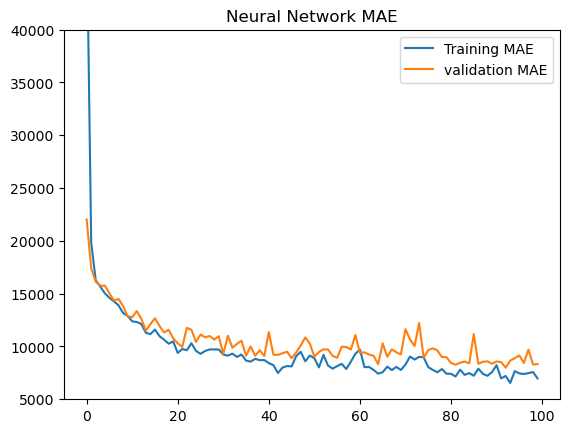

In [216]:
print("Neural Network Model:")
print(f"    mse: {mean_squared_error(y_test, y_pred_NN):.2f}")
print(f"    mae: {mean_absolute_error(y_test, y_pred_NN):.2f}")

# model.evaluate(X_test_, y_test)
plt.plot(history.history['mae'], label='Training MAE') # loss, mae, val_loss, val_mae
plt.plot(history.history['val_mae'], label='validation MAE')
plt.ylim(5000, 40000)
plt.legend()
plt.title('Neural Network MAE')
plt.show()

<font size='6'>Save Model</font>

In [217]:
os.makedirs(name='models', mode=0o755, exist_ok=True)
model_dir = os.path.join(os.getcwd(), 'models') 
best_NN_model.save(os.path.join(model_dir, 'NN_model.keras'))

In [218]:
for i, v in best_hyperparms.values.items():
    print(i, v)


unit_1 608
acti_1 tanh
unit_2 800
acti_2 tanh
unit_3 928
acti_3 relu
unit_4 1024
acti_4 relu
acti_output relu
lr 0.00903288929857157


<font size='6'>Predict</font>

In [219]:
y_pred_ex_ = new_NN_model.predict(example_df_)
example_df['predict_neural'] = y_pred_ex_
example_df

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


,age,gender,education_level,job_title,years_of_experience,predict_linear,predict_neural
0,26,male,Master,Data Analyst,0.0,51264.842596,50457.570312
1,26,female,Master,Data Analyst,0.0,48685.736363,70785.804688
2,27,male,Master,Data Analyst,0.0,46044.421676,40220.691406
3,27,female,Master,Data Analyst,0.0,43465.315444,62971.527344
4,27,male,Master,Data Analyst,1.0,61799.247431,57174.585938
5,27,female,Master,Data Analyst,1.0,59220.141198,79309.351562
